# Machine Learning at CoDaS-HEP 2024, Lesson 4: Survey of Architectures

In lesson 1, I introduced neural networks and the universal function approximation theorem. A single hidden layer implements _adaptive_ basis functions, more flexible than classic Taylor and Fourier series.

In lesson 2, we talked about issues involed in any fitting procedure, whether multilayered or not (i.e. a pure linear fit).

Lesson 3 was an open-ended project to build your own neural network.

In lesson 4, we will consider a variety of neural network "architectures": ways of building networks to improve learning for different types of problems.

In [262]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import awkward as ak

import sklearn.datasets
import torch
from torch import nn
from torch import optim

<br><br><br><br><br>

## Why should learning be "deep"?

**Deep learning:** a neural network with 3 or more layers (which is common nowadays).

<img src="../img/rise-of-deep-learning.svg" width="800">

* 2006‒2007: problems that _prevented_ the training of deep learning were solved.
* 2012: AlexNet, a GPU-enabled 8 layer network (with ReLU), won the ImageNet competition.
* 2015: ResNet, a GPU-enabled 152+ layer network (with skip-connections), won the ImageNet competition.

By 2015, it was clear that networks with many layers have more potential than one big hidden layer.

<br><br><br><br><br>

Why does it work?

One big hidden layer can approximate any shape, by optimizing adaptive basis functions, but according to [conventional wisdom](https://stats.stackexchange.com/a/223637/36505),

> Shallow networks are very good at memorization, but not so good at generalization.

That is, they have a tendency to overfit.

Why are multiple layers better?

<br><br><br><br><br>

Reminder of adaptive basis function:

$$ \psi(x; a, b) = \left\{\begin{array}{c l}
a + b x & \mbox{if } x > -a/b \\
0 & \mbox{otherwise} \\
\end{array}\right. $$

Function approximation with one hidden layer:

$$ f_j(x) = \sum_i^{N_1} \psi(x; a_{ij}, b_{ij}) c_{ij} $$

Function approximation with two hidden layers:

$$ f_k(x) = \sum_j^{N_2} \psi\left(x; \left[
\sum_i^{N_1} \psi(x; a_{i1}, b_{i1}) c_{i1}
\right], \left[
\sum_i^{N_1} \psi(x; a_{i2}, b_{i2}) c_{i2}
\right]\right) \left[
\sum_i^{N_1} \psi(x; a_{i3}, b_{i3}) c_{i3}
\right] $$

And so on: adaptively adaptive basis functions, then adaptively adaptively adaptive basis functions...

<br><br><br><br><br>

* Adding one more neuron in a single layer adds a wiggle to the fit function.
* Adding one more layer effectively folds the space under the next set of wiggly functions. Instead of fitting individual wiggles, they find symmetries in the data that (probably) correspond to an underlying relationship, rather than noise.

Consider this horseshoe-shaped decision boundary: with two well-chosen folds along the symmetries, it reduces to a simpler curve to fit. Instead of 4 ad-hoc wiggles, it's 2 folds and 1 wiggle.

<img src="../img/deep-learning-by-space-folding.svg" width="800">

Montúfar, Pascanu, Cho, & Bengio, [_On the Number of Linear Regions of Deep Neural Networks_](https://arxiv.org/abs/1402.1869) (2014).

<br><br><br><br><br>

Roy Keyes's fantastic demo ([with code](https://gist.github.com/jpivarski/f99371614ecaa48ace90a6025d430247)):

<img src="../img/network-layer-space-folding.png" width="800">

A uniform grid on the feature space (left; grid not shown) projected through the first layer's transformation shows what the underlying space looks like (right; grid is gray) before the second layer makes a linear decision boundary.

<br><br><br><br><br>

This is our first architecture, just a feed-forward "Multi Layer Perceptron" (MLP):

<img src="../img/artificial-neural-network-layers-2.svg" width="700">

Neurons in a layer add wiggles to the fitted function; layers add reflections and symmetries that are (probably) real structure.

<br><br><br><br><br>

## Autoencoders

Here is our second architecture, an **autoencoder**:

<img src="../img/artificial-neural-network-layers-autoencoder.svg" width="700">

The network structure is qualitatively like the first; the only difference is that the number of neurons shrinks to a "pinch point" and then returns to the original size.

The training is different: instead of trying to fit to known targets, we train the model to produce output that matches the input. When fully trained, it approximates the identity function.

This is **unsupervised learning**. Unlike **supervised learning**, in which we want the model to produce an expected answer, we let this model examine the data and come up with something on its own.

Before talking about it in detail, let's run an autoencoder on the same jet data that you classified with supervised learning.

In [232]:
hls4ml_lhc_jets_hlf = sklearn.datasets.fetch_openml("hls4ml_lhc_jets_hlf")

features_unnormalized = torch.tensor(hls4ml_lhc_jets_hlf["data"].values).float()

features = (features_unnormalized - features_unnormalized.mean(axis=0)) / features_unnormalized.std(axis=0)

In [166]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.shrinking = nn.Sequential(
            nn.Linear(16, 12),
            nn.Sigmoid(),
            nn.Linear(12, 8),
            nn.Sigmoid(),
            nn.Linear(8, 4),
            nn.Sigmoid(),
            nn.Linear(4, 2),
            nn.Sigmoid(),
        )
        self.growing = nn.Sequential(
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 8),
            nn.Sigmoid(),
            nn.Linear(8, 12),
            nn.Sigmoid(),
            nn.Linear(12, 16),
        )

    def forward(self, features):
        return self.growing(self.shrinking(features))

model = Autoencoder()

In [167]:
NUM_EPOCHS = 100
BATCH_SIZE = 1000

loss_function = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.03)

loss_vs_epoch = []
for epoch in range(NUM_EPOCHS):
    total_loss = 0

    for start_batch in range(0, len(features), BATCH_SIZE):
        stop_batch = start_batch + BATCH_SIZE

        optimizer.zero_grad()
    
        predictions = model(features[start_batch:stop_batch])
        loss = loss_function(predictions, features[start_batch:stop_batch])
        total_loss += loss.item()
    
        loss.backward()
        optimizer.step()

    loss_vs_epoch.append(total_loss)
    print(f"{epoch = } {total_loss = }")

epoch = 0 total_loss = 325.29809561371803
epoch = 1 total_loss = 191.3061871677637
epoch = 2 total_loss = 177.32360683381557
epoch = 3 total_loss = 169.3583533167839
epoch = 4 total_loss = 167.92090420424938
epoch = 5 total_loss = 165.48566557466984
epoch = 6 total_loss = 165.52079701423645
epoch = 7 total_loss = 161.4607362896204
epoch = 8 total_loss = 158.01348599791527
epoch = 9 total_loss = 155.35110571980476
epoch = 10 total_loss = 155.88811817765236
epoch = 11 total_loss = 151.56064367294312
epoch = 12 total_loss = 151.85434675216675
epoch = 13 total_loss = 151.44032472372055
epoch = 14 total_loss = 150.34826923906803
epoch = 15 total_loss = 150.65497985482216
epoch = 16 total_loss = 149.61602246761322
epoch = 17 total_loss = 149.13880340754986
epoch = 18 total_loss = 151.93106169998646
epoch = 19 total_loss = 156.43760101497173
epoch = 20 total_loss = 151.8343911021948
epoch = 21 total_loss = 148.96825237572193
epoch = 22 total_loss = 148.59056662023067
epoch = 23 total_loss = 1

<br><br><br><br><br>

To reproduce the 16-dimensional input data using only 2 dimensions in the middle, the model has to encode it with as little redundancy as possible.

We are asking the model to perform lossy compression—to _approximate_ the 16-dimensional data in 2 dimensions.

The data in 2 dimensional space looks very different from how it looks in the original 16 dimensions, but the biggest distinctions in one space are big distinctions in the other. This is an **embedding space** for the data.

Aside: in text processing networks, the physical space consists of exact words and the embedding space consists of _meanings_, which might not be one-to-one with words. (In this embedding space, relationships like

$$ \mbox{king} - \mbox{man} + \mbox{woman} = \mbox{queen} $$

hold.)

<img src="../img/neural-network-for-language.svg" width="300">

<br><br><br><br><br>

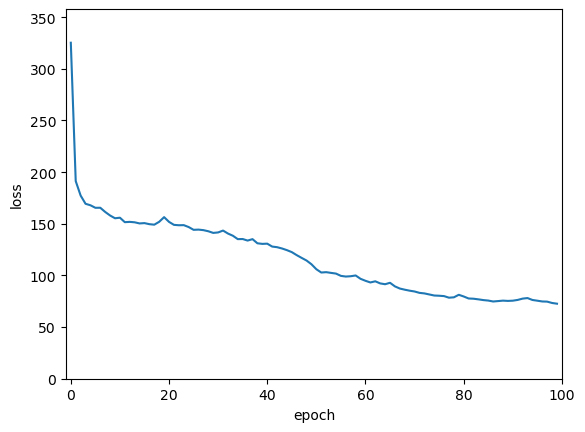

In [194]:
fig, ax = plt.subplots()

ax.plot(range(len(loss_vs_epoch)), loss_vs_epoch)
ax.set_xlim(-1, len(loss_vs_epoch))
ax.set_ylim(0, 1.1*max(loss_vs_epoch))
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

None

<br><br><br><br><br>

What does the data look like in the 2 dimensional space at the "pinch point" of the network?

In [198]:
embedded = model.shrinking(features).detach().numpy()

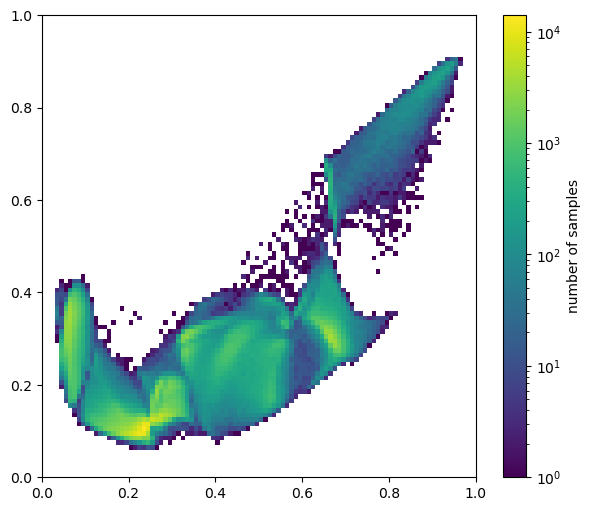

In [205]:
fig, ax = plt.subplots(figsize=(7, 6))

p = ax.hist2d(embedded[:, 0], embedded[:, 1], bins=(100, 100), range=((0, 1), (0, 1)), norm=mpl.colors.LogNorm())
fig.colorbar(p[-1], ax=ax, label="number of samples")
ax.axis([0, 1, 0, 1])

None

<br><br><br><br><br>

The model found some clumps; some clusters of different-looking jets.

Do these correspond to the `'g'`, `'q'`, `'t'`, `'w'`, `'z'` categories, the physically different hadronization mechanisms?

In [168]:
targets = torch.tensor(hls4ml_lhc_jets_hlf["target"].cat.codes.values).long()

In [169]:
hls4ml_lhc_jets_hlf["target"].cat.categories

Index(['g', 'q', 't', 'w', 'z'], dtype='object')

In [170]:
embedded_g = model.shrinking(features[targets == 0]).detach().numpy()
embedded_q = model.shrinking(features[targets == 1]).detach().numpy()
embedded_t = model.shrinking(features[targets == 2]).detach().numpy()
embedded_w = model.shrinking(features[targets == 3]).detach().numpy()
embedded_z = model.shrinking(features[targets == 4]).detach().numpy()

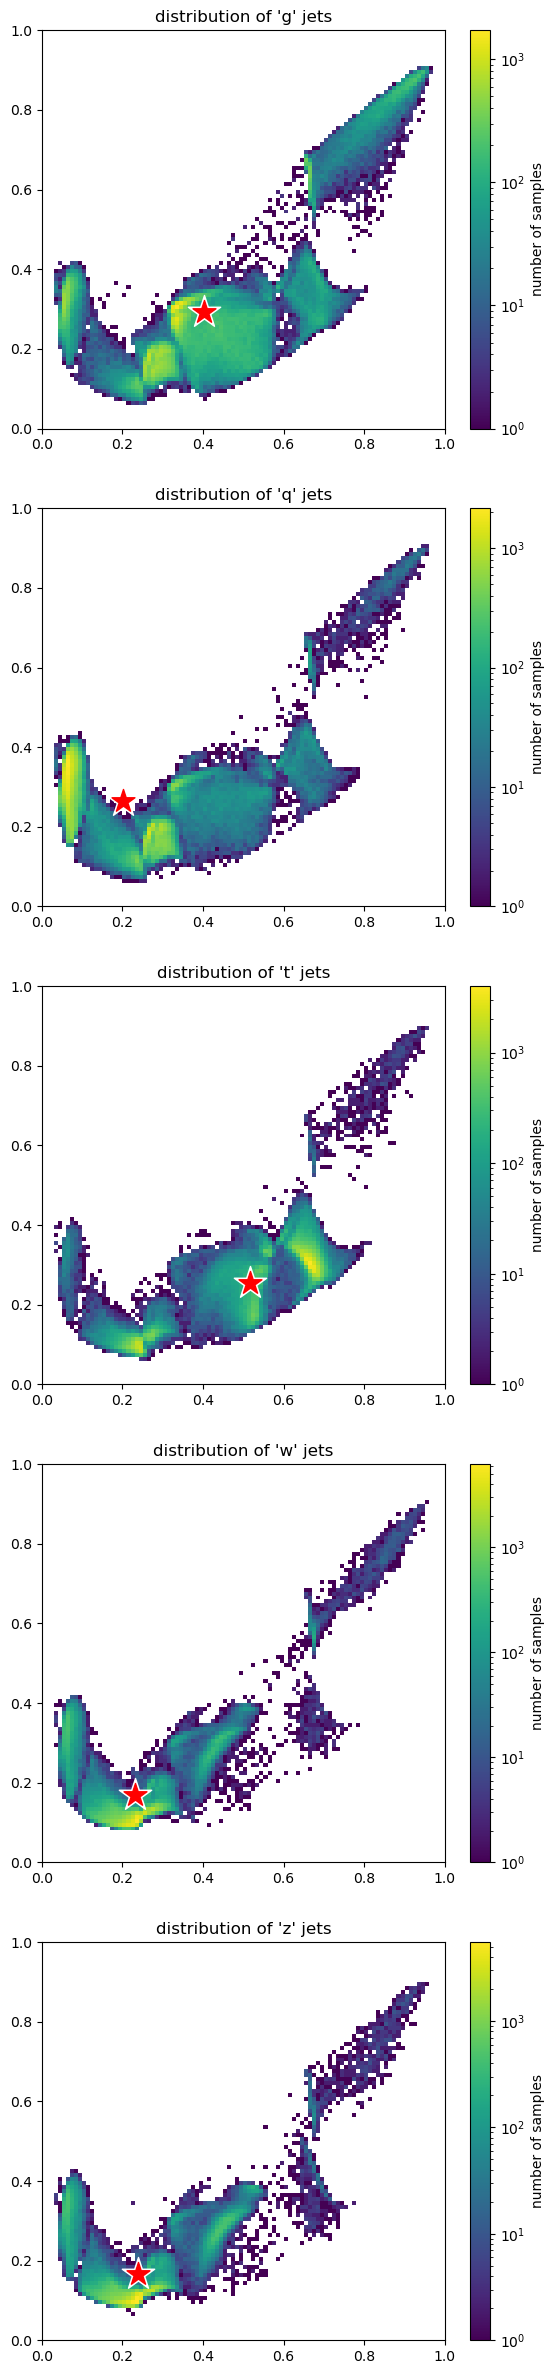

In [196]:
fig, axs = plt.subplots(5, 1, figsize=(6.5, 30))

ps = []
for (ax, (name, embedded)) in zip(axs, [
    ["g", embedded_g], ["q", embedded_q], ["t", embedded_t], ["w", embedded_w], ["z", embedded_z]
]):
    ps.append(ax.hist2d(embedded[:, 0], embedded[:, 1], bins=(100, 100), range=((0, 1), (0, 1)), norm=mpl.colors.LogNorm()))
    fig.colorbar(ps[-1][-1], ax=ax, label="number of samples")
    ax.scatter([embedded[:, 0].mean()], [embedded[:, 1].mean()], marker="*", s=600, color="white")
    ax.scatter([embedded[:, 0].mean()], [embedded[:, 1].mean()], marker="*", s=300, color="red")
    ax.set_title(f"distribution of '{name}' jets")
    ax.axis([0, 1, 0, 1])

None

Not quite. `'g'`, `'q'`, `'t'` populate different clusters from each other, although the model split them up with more granularity.

The `'w'`, `'z'` are different from the quark-gluon jets, but not different from each other.

It would be interesting to map these clusters back to the original 16-dimensional jets, to understand what these phenominological clusters mean, but not now.

Moving on!

<br><br><br><br><br>

## Variational autoencoder

Since we're interested in clusters in the autoencoder's "pinch point," why not encode them as distributions?

* An ordinary autoencoder maps input data to _points_ in a small-dimensional space, such as $(x_1, x_2, \ldots x_n)$.
* A variational autoencoder maps input data to _parameters of distributions_, such as $(\mu_1, \sigma_1, \mu_2, \sigma_2, \ldots, \mu_n, \sigma_n)$.

Values in the next layer are randomly generated from these distributions.

Thus, there are now three types of vector-transformation in the neural networks we have considered:

1. linear transformations
2. non-linear activation functions
3. random generation from distribution parameters.

Moving on!

<br><br><br><br><br>

## Convolutional neural network

The jet substructure dataset that we have been fitting consists of 16 hand-crafted features:

In [236]:
list(hls4ml_lhc_jets_hlf["data"].columns)

['zlogz',
 'c1_b0_mmdt',
 'c1_b1_mmdt',
 'c1_b2_mmdt',
 'c2_b1_mmdt',
 'c2_b2_mmdt',
 'd2_b1_mmdt',
 'd2_b2_mmdt',
 'd2_a1_b1_mmdt',
 'd2_a1_b2_mmdt',
 'm2_b1_mmdt',
 'm2_b2_mmdt',
 'n2_b1_mmdt',
 'n2_b2_mmdt',
 'mass_mmdt',
 'multiplicity']

But what if we don't know what are the best features to use?

What if these 16 aren't the best features?

<br><br><br><br><br>

Suppose, instead, we start with the raw data (ECAL and HCAL clusters).

The jet substructure is presented in its lowest-level form: images.

This file contains individual jet images, labeled by `'g'`, `'q'`, `'t'`, `'w'`, `'z'`.

In [239]:
with h5py.File("../data/jet-images.h5") as file:
    jet_images = file["images"][:]
    jet_labels = file["labels"][:]

jet_label_order = ["g", "q", "t", "w", "z"]

There are $80\,000$ images with 20×20 pixels each.

In [246]:
jet_images.shape

(80000, 20, 20)

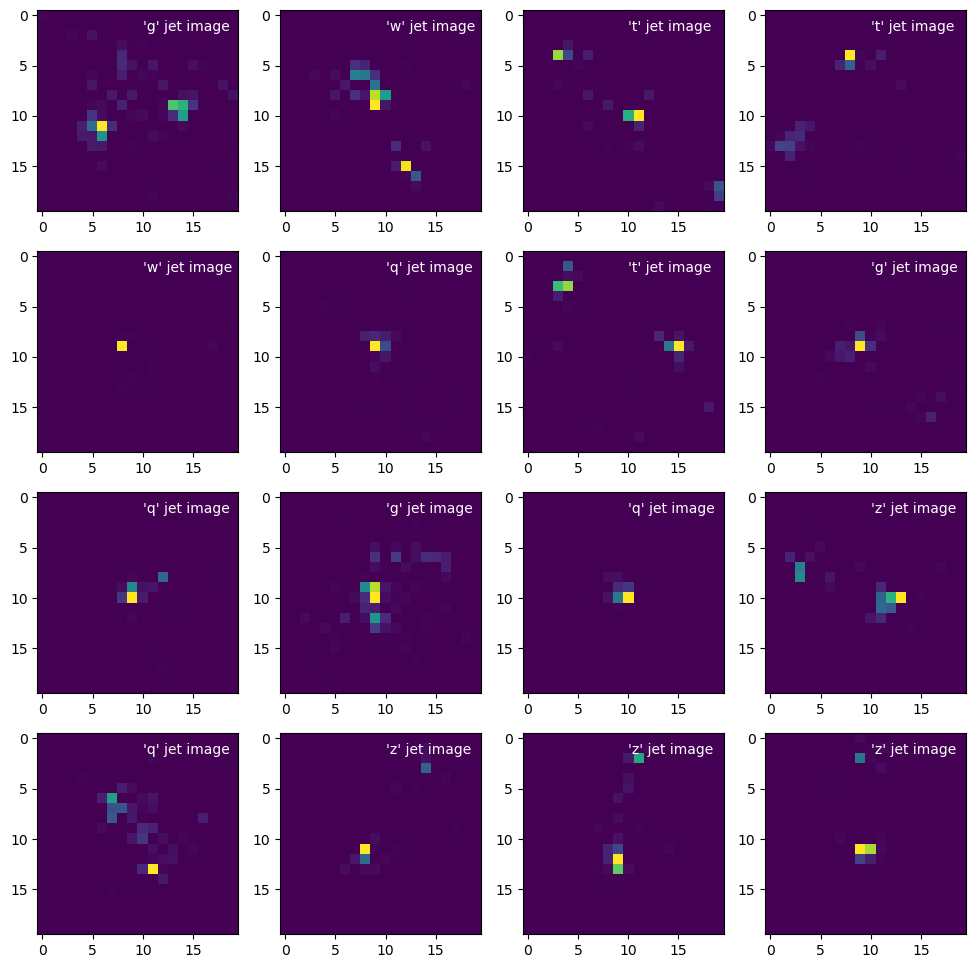

In [244]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(jet_images[i])
    ax.text(10, 1.5, f"'{jet_label_order[jet_labels[i]]}' jet image", color="white")

None

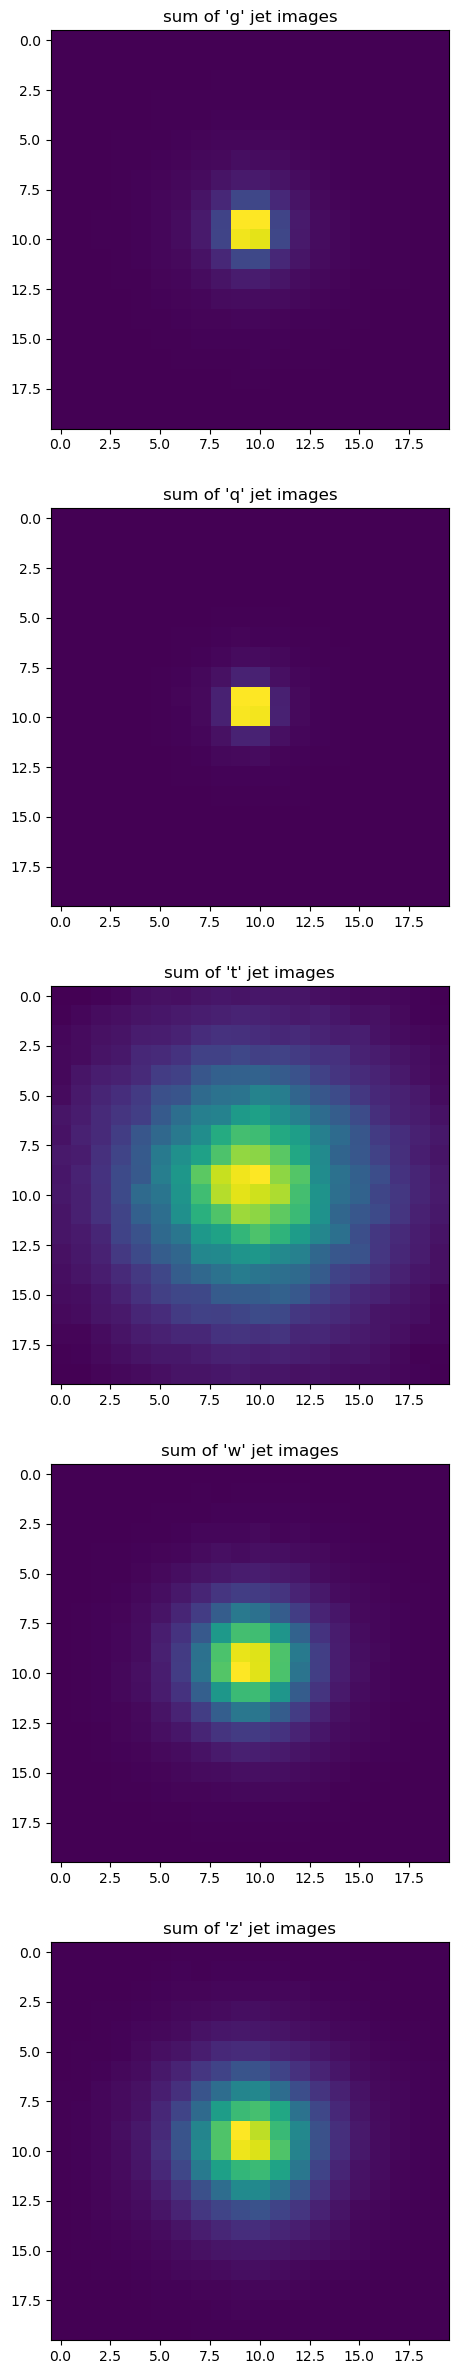

In [245]:
fig, axs = plt.subplots(5, 1, figsize=(6, 30))

for i, ax in enumerate(axs):
    ax.imshow(np.sum(jet_images[jet_labels == i], axis=0))
    ax.set_title(f"sum of '{jet_label_order[i]}' jet images")

None

<br><br><br><br><br>

Instead of a 16-dimensional input space, this dataset has a 400-dimensional input space (20 pixels times 20 pixels).

Just one fully connected layer would be a matrix with $400^2 = 160\,000$ parameters to fit.

We only have $80\,000$ images, so it would be highly overfitted.

<br><br><br><br><br>

Taking inspiration from biology (again):

<img src="../img/eye-neurons.jpg" width="400">

Photoreceptors for distant spatial points are not directly connected. Only nearby points are connected in the first layer.

<img src="../img/convolutional-planes.png" width="400">

A linear transformation of only nearby points is known as a [convolution](https://en.wikipedia.org/wiki/Convolution), so this is called a **Convolutional Neural Network** (CNN).

<br><br><br><br><br>

Before talking about it in detail, let's run a convolutional network on the jet images.

In [119]:
jet_images_tensor = torch.tensor(jet_images)[:, np.newaxis, :, :]
jet_labels_tensor = torch.tensor(jet_labels)

PyTorch wants this shape: (number of images, number of channels, height in pixels, width in pixels), so we make the 1 channel explicit with `np.newaxis`.

(An RGB image would have 3 channels, etc.)

In [247]:
jet_images_tensor.shape

torch.Size([80000, 1, 20, 20])

A PyTorch [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) has enough tunable parameters to describe a fixed-size convolution matrix (3×3 below) from a number of input channels (1 below) to a number of output channels (1 below).

The number of parameters _does not_ scale with the size of the image.

In [256]:
list(nn.Conv2d(1, 1, 3).parameters())

[Parameter containing:
 tensor([[[[ 0.2736, -0.0007, -0.2880],
           [-0.0342, -0.2988, -0.0642],
           [-0.2829,  0.2992,  0.2166]]]], requires_grad=True),
 Parameter containing:
 tensor([0.2307], requires_grad=True)]

A PyTorch [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) scales down an image by a fixed factor, by taking the maximum value in every $n \times n$ block.

It has _no_ tunable parameters.

Although not strictly necessary, it's a generally useful practice to pool convolutions, to reduce the total number of parameters and sensitivity to noise.

In [259]:
list(nn.MaxPool2d(2).parameters())

[]

The general strategy is to reduce the size of the image with each convolution (and max-pooling) while increasing the number of channels, so that the spatial grid gradually becomes an abstract vector.

Then do a normal fully-connected network to classify the vectors.

In [261]:
class ConvolutionalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional1 = nn.Sequential(
            nn.Conv2d(1, 5, 5),     # 1 input channel → 5 output channels, 5×5 convolution...
            nn.ReLU(),              #     input image: 20×20, convoluted image: 16×16 (because of edges)
            nn.MaxPool2d(2),        # scales down by taking the max in 2×2 squares, output is 8×8
        )
        self.convolutional2 = nn.Sequential(
            nn.Conv2d(5, 10, 5),    # 5 input channels → 10 output channels, 5×5 convolution...
            nn.ReLU(),              #     input image: 8×8, convoluted image: 4×4 (because of edges)
            nn.MaxPool2d(2),        # scales down by taking the max in 2×2 squares, output is 2×2
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(10 * 2*2, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
        )

    def forward(self, x):
        return self.fully_connected(torch.flatten(self.convolutional2(self.convolutional1(x)), 1))

model_without_softmax = ConvolutionalClassifier()

Although this has a lot of parameters ($3\,505$), it's less than the number of images ($80\,000$), which is much less than the number of inputs.

In [226]:
num_model_parameters = 0
for tensor_parameter in model_without_softmax.parameters():
    num_model_parameters += tensor_parameter.detach().numpy().size

num_model_parameters, len(jet_images_tensor)

(3505, 80000)

In [227]:
NUM_EPOCHS = 30
BATCH_SIZE = 1000

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_without_softmax.parameters(), lr=0.03)

loss_vs_epoch = []
for epoch in range(NUM_EPOCHS):
    total_loss = 0

    for start_batch in range(0, len(jet_images_tensor), BATCH_SIZE):
        stop_batch = start_batch + BATCH_SIZE

        optimizer.zero_grad()
    
        predictions = model_without_softmax(jet_images_tensor[start_batch:stop_batch])
        loss = loss_function(predictions, jet_labels_tensor[start_batch:stop_batch])
        total_loss += loss.item()
    
        loss.backward()
        optimizer.step()

    loss_vs_epoch.append(total_loss)
    print(f"{epoch = } {total_loss = }")

epoch = 0 total_loss = 103.76850819587708
epoch = 1 total_loss = 92.04020285606384
epoch = 2 total_loss = 90.4386932849884
epoch = 3 total_loss = 88.34286439418793
epoch = 4 total_loss = 88.21256494522095
epoch = 5 total_loss = 88.28438091278076
epoch = 6 total_loss = 87.17676317691803
epoch = 7 total_loss = 86.95003151893616
epoch = 8 total_loss = 86.1879905462265
epoch = 9 total_loss = 85.23314708471298
epoch = 10 total_loss = 84.86957252025604
epoch = 11 total_loss = 85.55939096212387
epoch = 12 total_loss = 83.02475696802139
epoch = 13 total_loss = 81.91610515117645
epoch = 14 total_loss = 81.23417609930038
epoch = 15 total_loss = 80.84091001749039
epoch = 16 total_loss = 80.04588913917542
epoch = 17 total_loss = 80.11455899477005
epoch = 18 total_loss = 79.68786054849625
epoch = 19 total_loss = 79.65701735019684
epoch = 20 total_loss = 78.93918251991272
epoch = 21 total_loss = 79.6267722249031
epoch = 22 total_loss = 81.82574790716171
epoch = 23 total_loss = 80.31988549232483
epoc

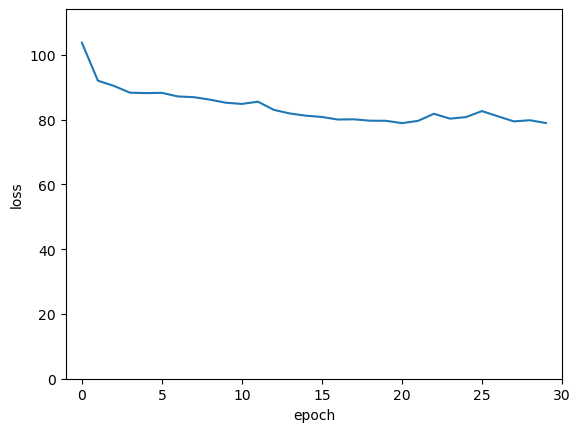

In [228]:
fig, ax = plt.subplots()

ax.plot(range(len(loss_vs_epoch)), loss_vs_epoch)
ax.set_xlim(-1, len(loss_vs_epoch))
ax.set_ylim(0, 1.1*max(loss_vs_epoch))
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

None

Let's see the accuracy, in terms of the confusion matrix.

In [229]:
model_with_softmax = nn.Sequential(
    model_without_softmax,
    nn.Softmax(dim=1),
)

In [230]:
predictions_tensor = model_with_softmax(jet_images_tensor)

confusion_matrix = np.array(
    [
        [
            (predictions_tensor[jet_labels_tensor == true_class].argmax(axis=1) == prediction_class).sum().item()
            for prediction_class in range(5)
        ]
        for true_class in range(5)
    ]
)
confusion_matrix

array([[10094,  1957,  2878,   651,   447],
       [ 2901, 10285,  1178,   933,   431],
       [  741,   422, 11242,  1765,  1905],
       [ 1581,  2749,    37, 10988,   745],
       [ 1485,  1903,   363,  5705,  6614]])

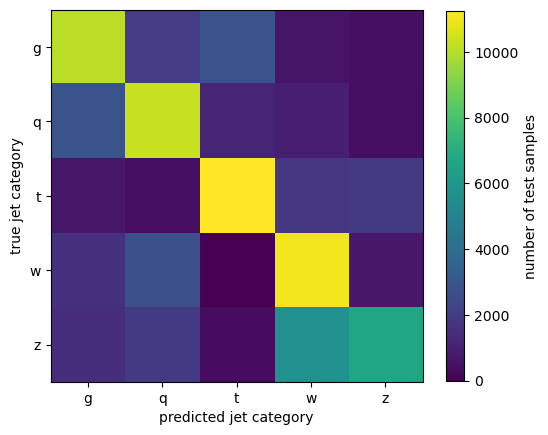

In [231]:
fig, ax = plt.subplots(figsize=(6, 6))

image = ax.imshow(confusion_matrix, vmin=0)
fig.colorbar(image, ax=ax, label="number of test samples", shrink=0.8)

ax.set_xticks(range(5), jet_label_order)
ax.set_yticks(range(5), jet_label_order)

ax.set_xlabel("predicted jet category")
ax.set_ylabel("true jet category")

None

<br><br><br><br><br>

Long before neural networks, (hand-coded) convolutions were used to detect edges in images.

These are low-level features of the image.

By repeating this process, convolutional neural networks 

<img src="../img/DWTBQ2-2018-ev-fig3.jpg" width="800">

<br><br>

Kunihiko Fukushima, [_Neocognitron: A self-organizing neural network model for a mechanism of pattern recognition unaffected by shift in position_](https://www.rctn.org/bruno/public/papers/Fukushima1980.pdf) (1980).

<img src="../img/higher-order-features.png" width="800">

<br><br>

"[Grandmother cell](https://en.wikipedia.org/wiki/Grandmother_cell)" refers to an old hypothesis that, in the human brain, _one cell_ encodes a very high-level concept like one's grandmother.

<br><br>

It sounds far fetched, but when Google trained an unsupervised convolutional network on a large set of YouTube videos, they were surprised by _one neuron_ that projected back onto the image space like this:

<img src="../img/cat-neuron.png" width="400">

This is what started the whole "AI discovers cats on the internet" thing.

<br><br><br><br><br>

There are now five types of vector-transformation in the neural networks we have considered:

1. linear transformations
2. non-linear activation functions
3. random generation from distribution parameters
4. small set of learned convolution parameters applied to large images
5. reducing an image size with pooling.

Moving on!

<br><br><br><br><br>

## Ragged data

Suppose you have data like the following—how would you pass this into a neural network?

In [306]:
event_data = ak.from_parquet("../data/SMHiggsToZZTo4L.parquet")
event_data

<Array [{run: 1, ...}, ..., {run: 1, ...}] type='299973 * {run: int32, lumi...'>

In [307]:
event_data.muon.pt

<Array [[63, 38.1, 4.05], [], [], ..., [], []] type='299973 * var * float32'>

<br><br><br><br><br>

PyTorch has a [torch.nested.nested_tensor](https://pytorch.org/docs/stable/nested.html) that can represent ragged numerical data.

(Notice that we have to turn this into Python lists first! PyTorch's [issue #112509](https://github.com/pytorch/pytorch/issues/112509) asks to fix this, and TensorFlow's [tf.RaggedTensor](https://www.tensorflow.org/guide/ragged_tensor) doesn't have this problem.)

In [308]:
muon_pt_tensor = torch.nested.nested_tensor(ak.to_list(event_data.muon.pt))

In [309]:
muon_pt_tensor[0]

tensor([63.0439, 38.1203,  4.0487])

In [310]:
muon_pt_tensor[1]

tensor([])

In [311]:
muon_pt_tensor[2]

tensor([])

In [312]:
muon_pt_tensor[3]

tensor([54.3327, 23.5153, 52.8711,  4.3286,  5.3478,  8.3934,  3.4901])

<br><br><br><br><br>

Unfortunately, one of the few things that you can do with it is turn it into a regular array by padding. (See [ak.pad_none](https://awkward-array.org/doc/main/reference/generated/ak.pad_none.html) and [ak.fill_none](https://awkward-array.org/doc/main/reference/generated/ak.fill_none.html) in Awkward Array.)

In [349]:
torch.nested.to_padded_tensor(muon_pt_tensor, -1)

tensor([[63.0439, 38.1203,  4.0487,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 4.3161,  4.3588,  5.6327,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]])

<br><br><br><br><br>

Other than computational inefficiency (iterating in Python, padded arrays in memory, extra-wide neural network layers to transform padded arrays), there are problems with data like this from a machine learning point of view.

A network trained on the padded tensor above would learn that many of the values on the right are `-1`, and it would learn _the exact order_ of muon values (which might or might not be sorted).

We want a model to learn about the muons as _unsorted collections of objects_.

We want **permutation invariance**.

<br><br><br><br><br>

[Zaheer, Kottur, Ravanbakhsh, Poczos, Salakhutdinov, & Smola, _Deep Sets_](https://arxiv.org/abs/1703.06114) (2017):

<img src="../img/deepset-theorem.png" width="900">

<br><br><br><br><br>

That is, to approximate a function $f(x_1, x_2, \ldots, x_M)$ with no dependence on the order of $x_1$, $x_2$, ... $x_M$, you can transform each $x_i$ into an independent vector, sum them, and then transform that vector.

These two transformations, $\Phi$ and $F$, can be neural networks, for complete generality.

$$ f(x_1, x_2, \ldots, x_M) = F \left( \sum_{i = 1}^M \Phi(x_i) \right) $$

<p style="text-align: center;"><img src="../img/deepset-diagram.png" width="500"></p>

The $\Phi$ functions should expand the $x_i$ vectors to a larger space so that enough information is preserved when they're summed.

The larger the typical number of $x_i$ (e.g. modeling all tracks, rather than just muons), the larger the output dimensionality of $\Phi$ should be.

The **latent space** (above) is the same kind of embedding that we saw in the pinch point of the autoencoder.

<br><br><br><br><br>

In [340]:
muon_kinematics = event_data["muon", ["pt", "eta", "phi"]]

muon_kinematics_tensor = torch.tensor(
    ak.to_numpy(ak.flatten(muon_kinematics)).view(np.float32).reshape(-1, 3)
)
muon_kinematics_tensor[:3]

tensor([[63.0439, -0.7187,  2.9680],
        [38.1203, -0.8795, -1.0325],
        [ 4.0487, -0.3208,  1.0385]])

In [335]:
event_data[0, "muon", ["pt", "eta", "phi"]]

<Array [{pt: 63, eta: -0.719, ...}, ..., {...}] type='3 * {pt: float32, eta...'>

In [347]:
Phi = nn.Sequential(
    nn.Linear(3, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
)

F = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
)

start = 0
for i, count in enumerate(ak.num(muon_kinematics)):
    one_event = muon_kinematics_tensor[start : start + count]
    start += count

    prediction = F(torch.sum(Phi(one_event), axis=0, keepdims=True))

<br><br><br><br><br>

The growing list of vector-transformations that can be used in neural networks:

1. linear transformations
2. non-linear activation functions
3. random generation from distribution parameters
4. small set of learned convolution parameters applied to large images
5. reducing an image size with pooling
6. adding arbitrarily many neural network outputs to make the next neural network input.

Moving on!

<br><br><br><br><br>

## Graph neural networks

What's a graph?

<img src="../img/13129_2024_67_Fig5_HTML.png" width="600">

<br><br><br><br><br>

A graph consists of distinct nodes (points) connected by edges (lines), in which only the connections matter, not where they're located/how they're drawn on a page.

* Nodes may have properties, such as a label.
* Edges may have properties, such as directions and weights.

<br><br><br><br><br>

What's the difference between a set

<img src="../img/example-set.svg" width="500">

<br><br>

and a graph?

<img src="../img/example-graph.svg" width="500">

<br><br><br><br><br>

A graph is a set with edges.

Graphs should have the same **permutation invariance** as sets.

We can model graph data in a way that is similar to DeepSets by adding an extra step that handles the edges.

Instead of adding $\Phi(x_i)$ for all nodes $x_i$ equally, as in DeepSets, **Graph Neural Networks** (GNNs) sum over individual neighborhoods (in various ways).

<img src="../img/graph-neighborhoods.svg" width="500">

[Ward, Joyner, Lickfold, Guo, & Bennamoun, _A Practical Tutorial on Graph Neural Networks_](https://arxiv.org/abs/2010.05234) (2020).

<br><br>

<img src="../img/gnn-equation.png" width="600">

<br><br><br><br><br>

The design space for GNNs is huge, but they involve using ordinary neural networks to make **latent spaces** ([a.k.a. embedding spaces](https://ai.stackexchange.com/q/11285)) and summing (or maximizing) over edge-connected neighbors in the graph.

Papers and webpages are filled with diagrams and equations with lots of subscripts that try to express this connectivity.

(See [the Neural Network Zoo](https://www.asimovinstitute.org/neural-network-zoo/).)

<br><br><br><br><br>

## Transformers (such as ChatGPT)

You'll see this diagram everywhere:

<img src="../img/transformer-architecture.svg" width="400">

[Vaswani, Shazeer, Parmar, Uszkoreit, Jones, Gomez, Kaiser, & Polosukhin, _Attention Is All You Need_](https://arxiv.org/abs/1706.03762) (2017).

It adds one more type of vector manipulation to the list:

1. linear transformations
2. non-linear activation functions
3. random generation from distribution parameters
4. small set of learned convolution parameters applied to large images
5. reducing an image size with pooling
6. adding arbitrarily many neural network outputs to make the next neural network input
7. concatenate vectors (make a $n_1 + n_2$-dimensional space from $n_1$-dimensional and $n_2$-dimensional spaces).

Basically, any array-oriented manipulation (that you can differentiate through, to help the optimizer) is fair game.